## 1 Decision Trees 

### 1.1 Training a Decision Tree


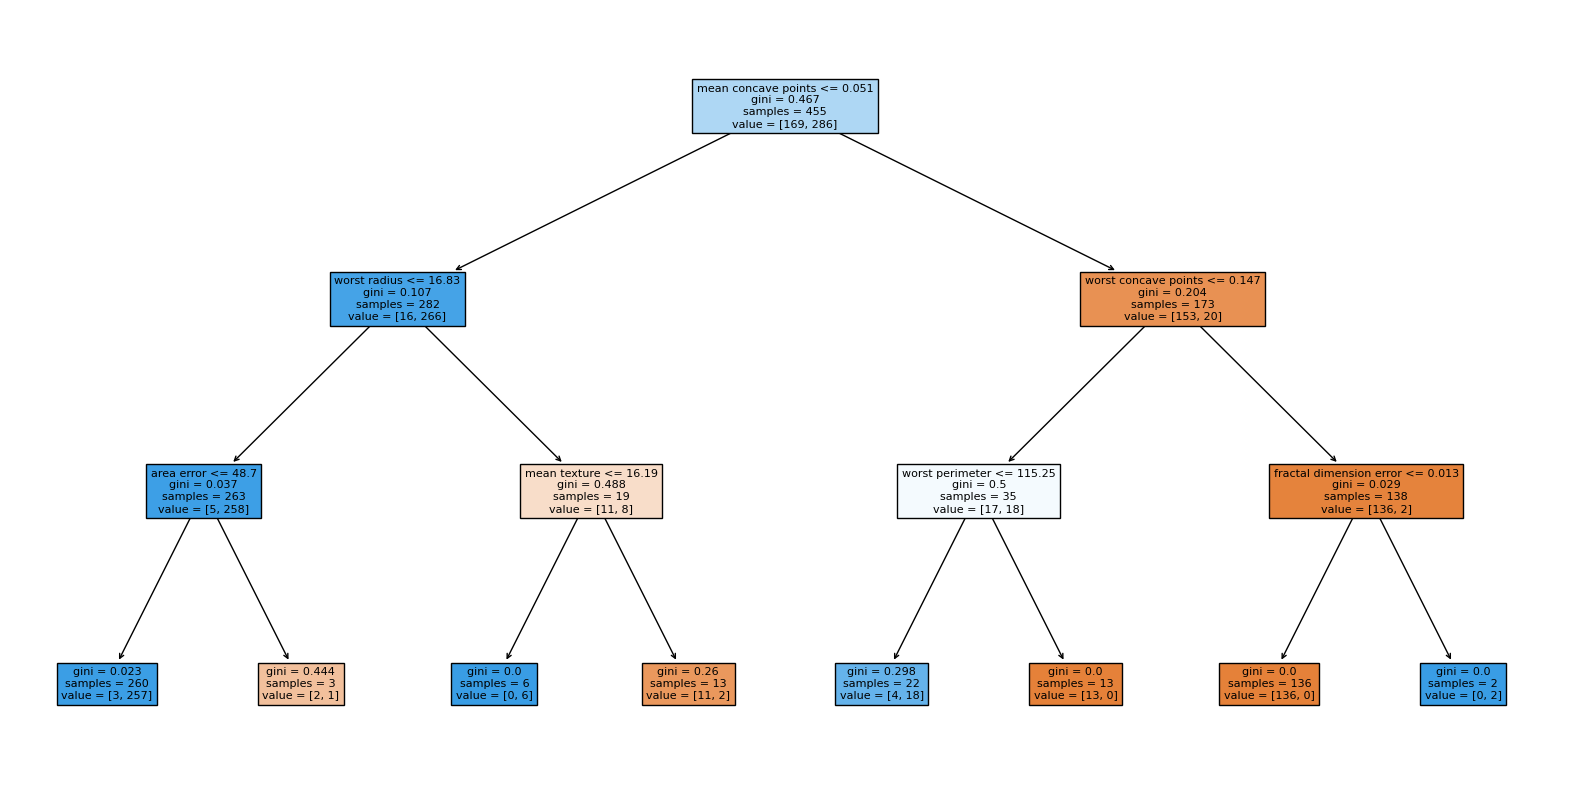

Accuracy: 0.9473684210526315


In [22]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split data into training and test sets with gini impurity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=data.feature_names)
plt.show()

# Evaluate the model
y_pred = tree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


### 1.2 Comparing with previous naive bayes model

In [31]:
import numpy as np

import matplotlib.pyplot as plt

# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target


numeric_y = np.array([1 if val == 'B' else 0 for val in y])


#custom splitting
def custom_train_test_split(X, y, test_size=0.29):

    np.random.seed(2)

    # Shuffle the indices
    indices = np.random.permutation(len(X))
    split_index = int((1 - test_size) * len(X))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, numeric_y)

def fit_naive_bayes(X, y):
    n_samples, n_features = X.shape
    classes = np.unique(y)
    n_classes = len(classes)

    mean = np.zeros((n_classes, n_features))
    var = np.zeros((n_classes, n_features))
    priors = np.zeros(n_classes)

    for idx, c in enumerate(classes):
        X_c = X[y == c]
        mean[idx, :] = X_c.mean()
        var[idx, :] = X_c.var()
        priors[idx] = X_c.shape[0] / float(n_samples)

    return classes, mean, var, priors

def predict_naive_bayes(X, classes, mean, var, priors, alpha=1):
    def pdf(class_idx, x, alpha=1, epsilon=1e-9):
        class_mean = mean[class_idx]
        class_var = var[class_idx] + alpha  # Add pseudocount (alpha) to the variance
        class_var = np.maximum(class_var, epsilon)  # Ensure variance is not zero
        numerator = np.exp(- (x - class_mean) ** 2 / (2 * class_var))
        denominator = np.sqrt(2 * np.pi * class_var)
        return numerator / denominator

    def predict(x):
        posteriors = []
        for idx, c in enumerate(classes):
            prior = np.log(priors[idx])
            class_conditional = np.sum(np.log(pdf(idx, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return classes[np.argmax(posteriors)]

    predictions = [predict(x) for x in X]
    return np.array(predictions)


classes, mean, var, priors = fit_naive_bayes(X_train, y_train)
predictions = predict_naive_bayes(X_train, classes, mean, var, priors)
train_accuracy = np.mean(predictions == y_train)


predictions = predict_naive_bayes(X_test, classes, mean, var, priors)
test_accuracy = np.mean(predictions == y_test)

print(train_accuracy, test_accuracy)


1.0 1.0


### 1.3 Feature Selection
Using the decision tree, obtain the most significant features. Select the most significant 5, 10, 15, and 20 features, train a linear classifier of your choice for
each, and compare the performance. Comment on the effect of this feature
selection approach on the performance.

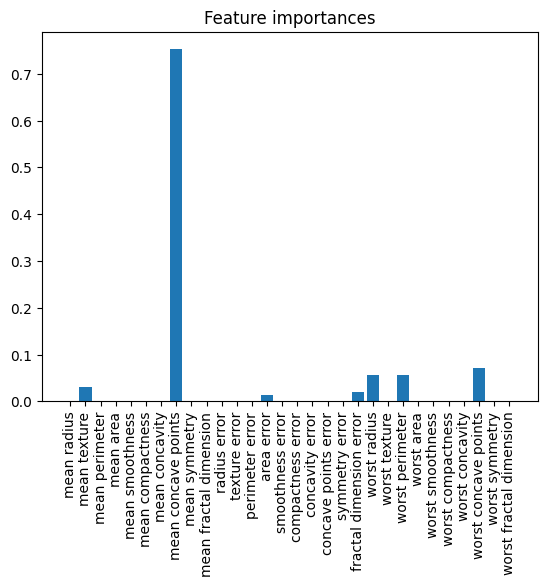

In [24]:
# obtaining the feature importance

importances = tree.feature_importances_

# Plot the feature importances

plt.figure()
plt.title("Feature importances")
plt.bar(data.feature_names, importances)
plt.xticks(rotation=90)
plt.show()


Accuracy: 0.956140350877193


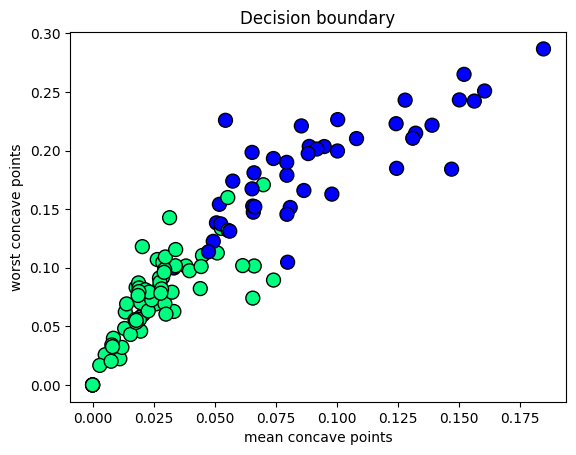

In [25]:
# get the most important 5 feature and train the linear classifier model with them

import numpy as np
from sklearn.linear_model import LogisticRegression

# Get the indices of the 5 most important features

indices = np.argsort(importances)[::-1][:5]

# Get the names of the 5 most important features

features = data.feature_names[indices]

# Get the training and test sets with only the 5 most important features

X_train_important = X_train[:, indices]

X_test_important = X_test[:, indices]

# Initialize and train the logistic regression model

log_reg = LogisticRegression(random_state=42)

log_reg.fit(X_train_important, y_train)

# Evaluate the model

y_pred = log_reg.predict(X_test_important)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot the decision boundary

plt.figure()

plt.title("Decision boundary")

plt.xlabel(features[0])

plt.ylabel(features[1])

plt.scatter(X_test_important[:, 0], X_test_important[:, 1], c=y_test, cmap="winter", edgecolors="k", s=100) 

plt.show()


In [26]:
# we should repeat this process for different number of features and compare the results (10, 15, 20)

# Get the indices of the 10 most important features

from sklearn.preprocessing import MinMaxScaler, StandardScaler

numbers = [5, 10, 15, 20]

for number in numbers:
    indices = np.argsort(importances)[::-1][:number]
    features = data.feature_names[indices]
    X_train_important = X_train[:, indices]
    X_test_important = X_test[:, indices]
    log_reg = LogisticRegression(max_iter = 1000, random_state=42)
    log_reg.fit(X_train_important, y_train)
    y_pred = log_reg.predict(X_test_important)
    print(f"Accuracy with {number} features:", accuracy_score(y_test, y_pred))


Accuracy with 5 features: 0.956140350877193
Accuracy with 10 features: 0.956140350877193
Accuracy with 15 features: 0.9824561403508771
Accuracy with 20 features: 0.9912280701754386


### 1.4 Training a Random Forest
Train a random forest using all the original features and compare its test
performance with the decision tree in 1. Please plot the change in test and
training performances with the varying number of trees in the forest.

In [18]:
# train random forest with various number of trees and compare the results

from sklearn.ensemble import RandomForestClassifier

numbers = [5, 10, 50, 100]

for number in numbers:

    forest = RandomForestClassifier(n_estimators=number, random_state=42)

    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_test)

    print(f"Accuracy with {number} trees:", accuracy_score(y_test, y_pred))

Accuracy with 5 trees: 0.9473684210526315
Accuracy with 10 trees: 0.956140350877193
Accuracy with 50 trees: 0.9649122807017544
Accuracy with 100 trees: 0.9649122807017544


##  3. Clustering

In this task, please use the 4-class MNIST data you use in the second task.
1. Is normalizing the data points before running k-means important? Please
explain.
2. Please implement the k-means algorithm from scratch using Euclidean dis-
tance. Find 4 clusters using the flattened images. Repeat this experiment
for the features you extracted. Please compare the clustering outputs using
the external (clustering accuracy)and internal (SSE) metrics.
3. Please repeat step 2 with cosine similarity instead of Euclidean distance. Did
you observe a significant difference in the clustering results?
3

# 3. CLUSTERING

## 3.1

In [15]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to initialize centroids randomly
def initialize_centroids(X, n_clusters):
    return X[np.random.choice(X.shape[0], n_clusters, replace=False)]

# Function to update centroids based on current labels
def update_centroids(X, labels, n_clusters):
    return np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])

# Main K-Means algorithm function
def kmeans(X, n_clusters, max_iters=100):
    centroids = initialize_centroids(X, n_clusters)
    for _ in range(max_iters):
        labels = assign_labels(X, centroids)
        new_centroids = update_centroids(X, labels, n_clusters)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels, centroids

def load_and_preprocess_data():
    # Load MNIST data
    mnist = fetch_openml('mnist_784', version=1, as_frame=False) 

    # Filter for digits 2, 3, 8, 9
    indices = np.isin(mnist.target.astype(int), [2, 3, 8, 9])
    X = mnist.data[indices].astype(float)
    y = mnist.target[indices].astype(int)

    # Normalize the data
    X /= 255.0

    return X, y


In [ ]:
# Function to assign labels based on closest centroid by Euclidean distance
def assign_labels(X, centroids):
    return np.argmin(np.linalg.norm(X[:, None] - centroids, axis=-1), axis=-1)


In [19]:

# Using the functions
X, y = load_and_preprocess_data()


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [18]:
n_clusters = 4  # Example: 4 clusters
labels, centroids = kmeans(X, n_clusters)

print("Cluster Assignments:", labels)
print("Final Centroids:", centroids)

Cluster Assignments: [3 1 0 ... 3 1 2]
Final Centroids: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
np.unique(centroids)

array([0.00000000e+00, 1.93442774e-06, 2.66275242e-06, ...,
       8.31999779e-01, 8.35017597e-01, 8.42090032e-01])

In [7]:
labels[0:10]

array([3, 0, 1, 2, 2, 0, 1, 1, 1, 2])

In [20]:
# calculate clustering accuracy
from scipy.stats import mode

def calculate_clustering_accuracy(y_true, y_pred):
    # Calculate the most common true label for each predicted cluster
    labels = np.zeros_like(y_pred)
    for i in range(4):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask])[0]
    return labels

def calculate_sse(X, labels, centroids):
    sse = 0
    for i in range(4):
        cluster_points = X[labels == i]
        sse += np.sum((cluster_points - centroids[i]) ** 2)
    return sse

# Evaluate the clustering accuracy

from sklearn.metrics import accuracy_score

y_clustered = calculate_clustering_accuracy(y, labels)

accuracy = accuracy_score(y, y_clustered)

print("Clustering Accuracy:", accuracy)

sse = calculate_sse(X, labels, centroids)

print("SSE:", sse)

Clustering Accuracy: 0.7484416421867164
SSE: 1217835.3655996728


/var/folders/sj/b29xgfjn237gd2tgvs743q8m0000gn/T/ipykernel_97406/3016575277.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_true[mask])[0]


## 3.2 Feature Extraction

In [10]:
# apply PCA 0.95 variance

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(X)

In [13]:
labels, centroids = kmeans(X_pca, n_clusters)

y_clustered = calculate_clustering_accuracy(y, labels)

accuracy = accuracy_score(y, y_clustered)

print("Clustering Accuracy with PCA:", accuracy)

sse = calculate_sse(X_pca, labels, centroids)

print("SSE with PCA:", sse)

Clustering Accuracy with PCA: 0.78125671705954
SSE with PCA: 1144577.8856176261


/var/folders/sj/b29xgfjn237gd2tgvs743q8m0000gn/T/ipykernel_97406/3016575277.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_true[mask])[0]


## 3.3 Cosine Similarity

In [16]:
def cosine_distance(a, b):
    """Compute the cosine distance between two arrays."""
    dot_product = np.dot(a, b.T)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b, axis=1)
    return 1 - dot_product / (norm_a * norm_b)

def assign_labels(X, centroids):
    """Assign labels based on the closest centroid using cosine distance."""
    # Calculate distances from each data point to each centroid
    distances = np.array([cosine_distance(x, centroids) for x in X])
    # Assign labels based on the nearest centroid (smallest distance)
    return np.argmin(distances, axis=1)


In [61]:
# Main K-Means algorithm function with cosine distance

n_clusters = 4  # Example: 4 clusters
labels, centroids = kmeans(X, n_clusters)


y_clustered = calculate_clustering_accuracy(y, labels)

accuracy = accuracy_score(y, y_clustered)
sse = calculate_sse(X, labels, centroids)

print("Clustering Accuracy:", accuracy)
print("SSE:", sse)

Clustering Accuracy: 0.7462921831339113
SSE: 1217850.1532016108


/var/folders/sj/b29xgfjn237gd2tgvs743q8m0000gn/T/ipykernel_37169/2548361254.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_true[mask])[0]


In [63]:
centroids.shape

(4, 784)